## Time Series Forecasting

**Importing Libraries**

In [15]:
import os.path
# Import necessary libraries
import pickle
import pandas as pd  # Pandas for data manipulation
import numpy as np   # NumPy for numerical computations
import matplotlib.pyplot as plt  # Matplotlib for plotting
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test for stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Plot ACF and PACF
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for time series analysis
from sklearn.preprocessing import MinMaxScaler  # For data scaling
from sklearn.metrics import mean_squared_error  # For evaluating model performance
import torch  # PyTorch for deep learning
import torch.nn as nn  # Neural network module in PyTorch
from tqdm.notebook import tqdm  # Progress bar for loops

In [16]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Load the dataset
data1 = pd.read_csv("data/AMZN.csv")  # Assuming dataset is in a folder named "data"
data1['Date'] = pd.to_datetime(data1['Date'])  # Convert 'Date' column to datetime format
data1.set_index('Date', inplace=True)  # Set 'Date' column as index for time series data

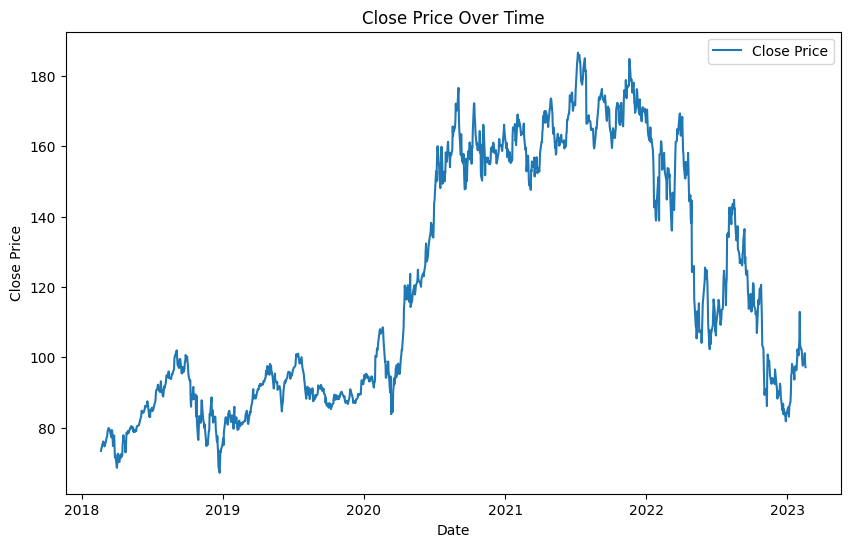

In [18]:
# Initial Plots of the Data
plt.figure(figsize=(10, 6))
plt.plot(data1.index, data1['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [19]:
# Perform Stationarity Tests
def check_stationarity(data):
    """
    This function performs the Augmented Dickey-Fuller Test (ADF Test) to check the stationarity of a time series.

    Args:
        data: A pandas Series or numpy array containing the time series data.

    Returns:
        None (prints the results of the stationarity test).
    """
    result = adfuller(data)  # Perform ADF test
    print('ADF Statistic:', result[0])  # Print ADF Statistic
    print('p-value:', result[1])  # Print p-value
    print('Critical Values:', result[4])  # Print Critical Values
    if result[1] < 0.05:
        print("Data is stationary")  # If p-value is less than 0.05, data is considered stationary
    else:
        print("Data is not stationary")  # If p-value is greater than 0.05, data is not stationary

ADF Statistic: -1.6578089913331715
p-value: 0.4529710546516681
Critical Values: {'1%': -3.4355588184378574, '5%': -2.8638402312881497, '10%': -2.5679946684494275}
Data is not stationary


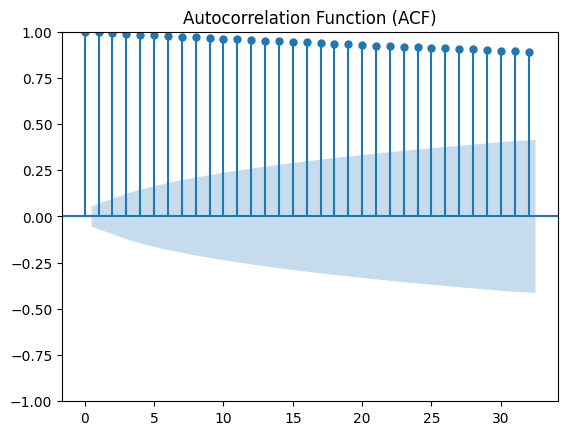

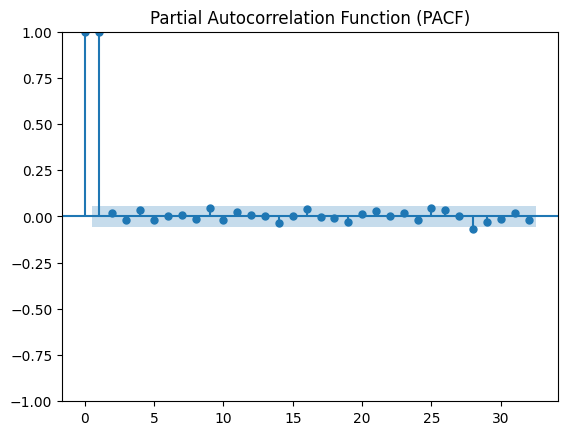

In [20]:
check_stationarity(data1['Close'])

# Plot ACF and PACF
plot_acf(data1['Close'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data1['Close'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

ADF Statistic: -36.25077933242771
p-value: 0.0
Critical Values: {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}
Data is stationary


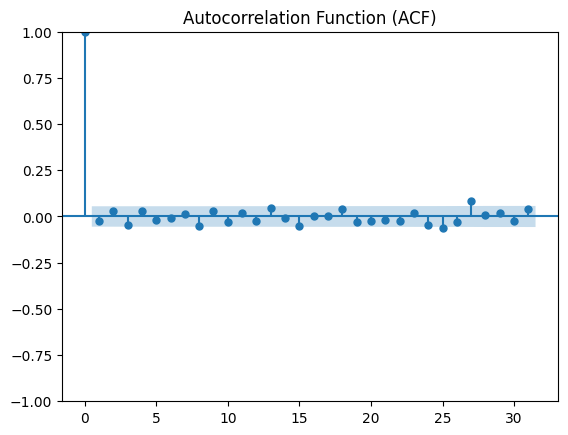

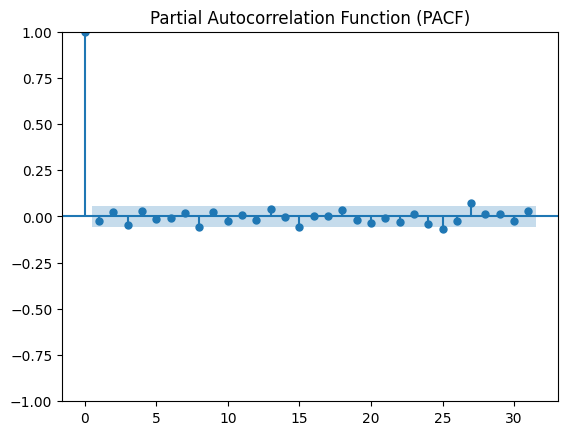

In [21]:
# Make the Data Stationary
data1_diff = data1['Close'].diff().dropna()

# Check Stationarity Again
check_stationarity(data1_diff)

# Plot ACF and PACF
plot_acf(data1_diff)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data1_diff)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

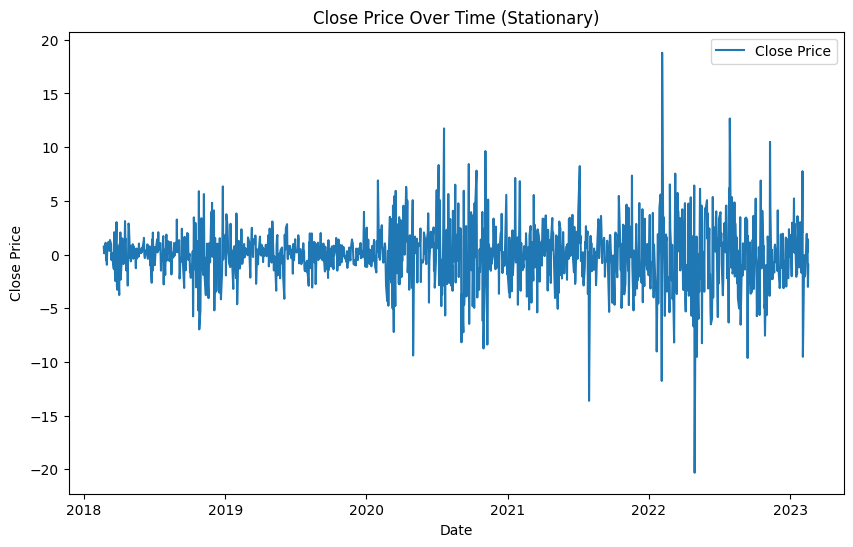

In [22]:
# Initial Plots of the Stationary Data
plt.figure(figsize=(10, 6))
plt.plot(data1_diff.index, data1_diff, label='Close Price')
plt.title('Close Price Over Time (Stationary)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [23]:
def save_arima_model(model, filename):
    """
    Save the ARIMA model to a file using pickle.
    
    Parameters:
    - model: Trained ARIMA model object
    - filename: Name of the file to save the model to
    """
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print("Model saved successfully as", filename)

def save_pytorch_model(model, filename):
    """
    Save the PyTorch model to a file.
    
    Parameters:
    - model: PyTorch model object
    - filename: Name of the file to save the model to
    """
    torch.save(model.state_dict(), filename)
    print("PyTorch model saved successfully as", filename)

In [24]:
# Define ARIMA Model and Find Best Parameters
def find_best_arima_parameters(data):
    """
    This function iterates through different combinations of ARIMA parameters (p, d, q) to find the best model
    based on the Akaike Information Criterion (AIC).

    Args:
        data: A pandas Series or numpy array containing the time series data.

    Returns:
        tuple: A tuple containing the best parameters (p, d, q) for the ARIMA model.
    """
    best_aic = np.inf  # Initialize the best AIC value with positive infinity
    best_order_ = None  # Initialize the best order tuple
    for p in tqdm(range(3)):  # Loop over AR order (p)
        for d in range(2):  # Loop over differencing (d)
            for q in range(3):  # Loop over MA order (q)
                try:
                    model_ = ARIMA(data, order=(p, d, q))  # Create ARIMA model with current parameters
                    results = model_.fit()  # Fit the ARIMA model
                    if results.aic < best_aic:  # Check if current AIC is better than the best AIC
                        best_aic = results.aic  # Update best AIC value
                        best_order_ = (p, d, q)  # Update best order tuple with current parameters
                except:
                    continue  # Continue to the next iteration if an error occurs
    return best_order_  # Return the best parameters (p, d, q) for the ARIMA model

In [25]:
best_order = find_best_arima_parameters(data1_diff) # Find best ARIMA parameters
print('Best ARIMA Order:', best_order)

  0%|          | 0/3 [00:00<?, ?it/s]

Best ARIMA Order: (2, 0, 2)


In [26]:
def split_time_series_data(data, test_size=24, scale=False):
    """
    This function splits a time series data into training and testing sets.

    Args:
        data: A pandas Series or numpy array containing the time series data.
        test_size (int): Number of data points to be included in the test set.
        scale (bool): Whether to scale the data using Min-Max scaling.

    Returns:
        tuple: A tuple containing the training and testing sets. If scale=True, it also returns the scaler object.
    """
    train_data = data[:-test_size]  # Select data points for training set
    test_data = data[-test_size:]    # Select data points for test set

    if scale:  # Check if scaling is required
        scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize Min-Max scaler
        train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(train_data.shape)  # Scale training data
        test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).reshape(test_data.shape)  # Scale test data using same scaler
        return train_data_scaled, test_data_scaled, scaler  # Return scaled training and testing sets along with scaler object
    else:
        return train_data, test_data  # Return original training and testing sets

In [27]:
# Split the data into train and test sets
stat_train, stat_test = split_time_series_data(data1_diff)

In [28]:
# Train ARIMA Model
model_arima_stat = ARIMA(stat_train, order=best_order)  # Initialize ARIMA model with best parameters
model_arima_stat_fit = model_arima_stat.fit()  # Fit the ARIMA model to the training data
model_arima_stat_fit  # Display model summary

In [31]:
import os
models_path = os.path.join('trained_models')
os.makedirs(models_path)

In [32]:
model_path = os.path.join(models_path, 'arima_stat.pkl')
save_arima_model(model_arima_stat_fit, model_path)

Model saved successfully as trained_models\arima_stat.pkl


In [33]:
# Define a function to plot data
def plot(values, title):
    """
    Plot the given values with a specified title.

    Args:
        values: Data to be plotted.
        title: Title for the plot.

    Returns:
        None
    """
    plt.plot(values, label=title)  # Plot the values with specified title
    plt.legend()  # Show legend
    plt.show()  # Display the plot

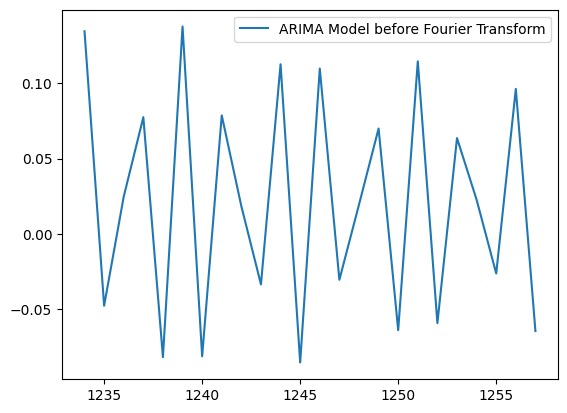

In [34]:
# Plot the forecasted values from the ARIMA model before Fourier transform
plot(model_arima_stat_fit.forecast(steps=24), 'ARIMA Model before Fourier Transform')

In [35]:
# Introduce Fourier Decomposition
from scipy.fft import fft, ifft

def fourier_decomposition(data, periods):
    """
    Perform Fourier decomposition on the given data.

    Args:
        data: Input time series data.
        periods: Number of periods to keep in the decomposition.

    Returns:
        numpy.ndarray: Reconstructed data after Fourier decomposition.
    """
    data_np = data.to_numpy()  # Convert data to NumPy array
    fft_data = fft(data_np)  # Compute Fast Fourier Transform (FFT)
    fft_data[periods:] = 0  # Keep only the first 'periods' components
    reconstructed_data_ = ifft(fft_data)  # Compute Inverse Fast Fourier Transform (IFFT)
    return np.real(reconstructed_data_)  # Return the real part of the reconstructed data

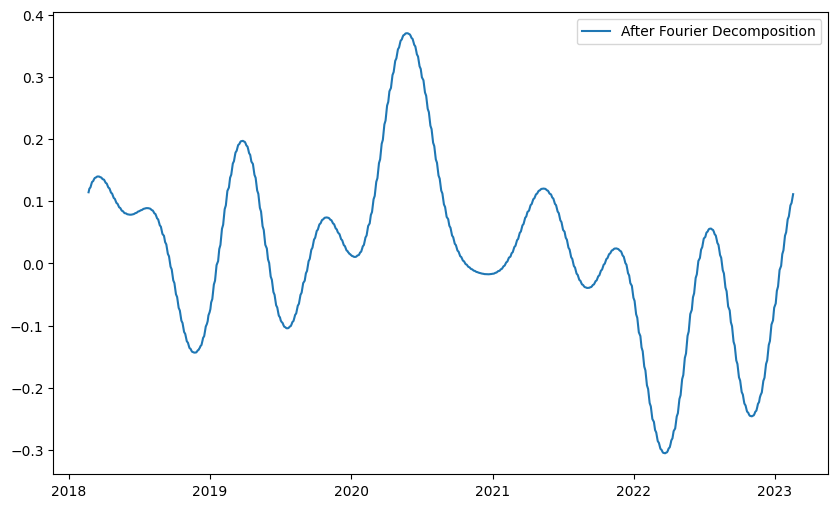

In [36]:
n_periods = 10  # Number of periods to keep in the decomposition
reconstructed_data = fourier_decomposition(data1_diff, n_periods)  # Perform Fourier decomposition

# Plot the reconstructed data after Fourier decomposition
plt.figure(figsize=(10, 6))
plt.plot(data1_diff.index, reconstructed_data, label='After Fourier Decomposition')
plt.legend()
plt.show()

In [37]:
# Split the data into train and test sets after Fourier decomposition
fourier_train, fourier_test = split_time_series_data(reconstructed_data)

In [38]:
fourier_train  # Display the training data after Fourier decomposition

array([ 0.11449687,  0.11739309,  0.12010756, ..., -0.02375708,
       -0.01711488, -0.01053498])

In [39]:
model_arima_fourier = ARIMA(fourier_train, order=best_order)  # Initialize ARIMA model with best parameters after Fourier decomposition
model_arima_fourier_fit = model_arima_fourier.fit()  # Fit the ARIMA model to the training data after Fourier decomposition
model_arima_fourier_fit  # Display model summary

In [40]:
model_path = os.path.join(models_path, 'arima_fourier.pkl')
save_arima_model(model_arima_fourier_fit, model_path)

Model saved successfully as trained_models\arima_fourier.pkl


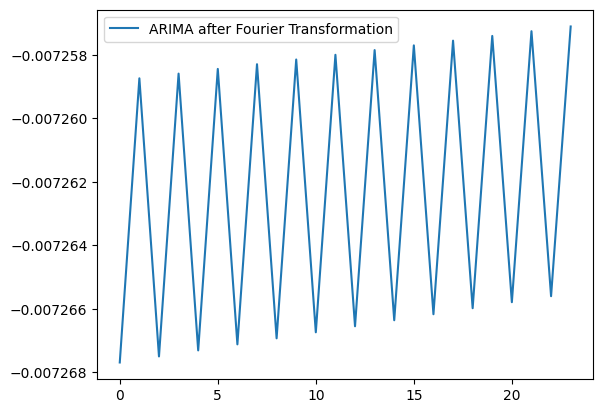

In [41]:
# Plot the forecasted values from the ARIMA model after Fourier transformation
plot(model_arima_fourier_fit.forecast(steps=24), 'ARIMA after Fourier Transformation')

In [42]:
# Build LSTM Model
class LSTMModel(nn.Module):
    """
    LSTMModel class defines the architecture of the LSTM model.

    Args:
        input_size (int): Number of features in the input.
        hidden_layer_size (int): Number of units in the hidden layer.
        output_size (int): Number of features in the output.

    Attributes:
        lstm: LSTM layer.
        linear: Linear layer.
        hidden_cell: Hidden cell state for LSTM.
    """
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)  # LSTM layer
        self.linear = nn.Linear(hidden_layer_size, output_size)  # Linear layer
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),  # Initialize hidden cell state for LSTM
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        """
        Forward pass through the LSTM model.

        Args:
            input_seq (torch.Tensor): Input sequence.

        Returns:
            torch.Tensor: Predictions from the model.
        """
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)  # LSTM forward pass
        preds = self.linear(lstm_out.view(len(input_seq), -1))  # Linear layer forward pass
        return preds[-1]  # Return predictions for the last time step

In [43]:
# Define a function to prepare data for LSTM model
def prepare_data(data, steps):
    """
    Prepare data for LSTM model training.

    Args:
        data (numpy.ndarray): Time series data.
        steps (int): Number of time steps to consider in each input sequence.

    Returns:
        tuple: Tuple containing input sequences (X) and corresponding output values (y).
    """
    x, y_ = [], []
    for i_ in tqdm(range(len(data)-steps)):
        x.append(data[i_:(i_+steps)])  # Prepare input sequences
        y_.append(data[i_+steps])  # Prepare corresponding output values
    return np.array(x), np.array(y_)

In [44]:
# Define the number of time steps for input sequences
n_steps = 30

# Prepare data for LSTM model training
X, y = prepare_data(np.array(reconstructed_data), n_steps)

# Split the data into train and test sets after scaling
x_train, x_test, scaler_input = split_time_series_data(X, scale=True)  # Scale input data and split into train and test sets
y_train, y_test, scaler_output = split_time_series_data(y, scale=True)  # Scale output data and split into train and test sets

  0%|          | 0/1228 [00:00<?, ?it/s]

In [45]:
# Convert training data to PyTorch tensors of float type
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

# Initialize the LSTM model, loss function, and optimizer
model_lstm = LSTMModel()  # Initialize the LSTM model
loss_function = nn.MSELoss()  # Mean Squared Error loss function
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

In [46]:
# Check if CUDA (GPU) is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [47]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2050'

In [48]:
# Move the model to the appropriate device (GPU or CPU)
model_lstm = model_lstm.to(device)

In [50]:
# Define the number of epochs for training
epochs = 20

# Initialize an empty list to store losses for each epoch
losses = []

# Loop over the specified number of epochs for training
for epoch in tqdm(range(1, epochs + 1)):  # Start epoch from 1
    epoch_loss = 0  # Initialize epoch loss to 0
    for seq, labels in zip(x_train, y_train):  # Iterate over training sequences and labels
        seq, labels = seq.to(device), labels.to(device)  # Move sequences and labels to device (GPU or CPU)
        optimizer.zero_grad()  # Zero the gradients
        model_lstm.hidden_cell = (torch.zeros(1, 1, model_lstm.hidden_layer_size).to(device),  # Reset hidden cell states
                                  torch.zeros(1, 1, model_lstm.hidden_layer_size).to(device))

        y_pred = model_lstm(seq)  # Forward pass: compute predicted values

        single_loss = loss_function(y_pred, labels)  # Compute loss for the current sequence
        single_loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters based on gradients

        epoch_loss += single_loss.item()  # Accumulate the loss for the epoch

    # Calculate and print average loss for the epoch
    epoch_loss /= len(x_train)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch}/{epochs}], Loss: {epoch_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.0018817190997017126
Epoch [2/20], Loss: 0.003134324611229583
Epoch [3/20], Loss: 0.005928822688932216
Epoch [4/20], Loss: 0.007853160759230263
Epoch [5/20], Loss: 0.00716447822233378
Epoch [6/20], Loss: 0.004477421080410946
Epoch [7/20], Loss: 0.0023421850039821684
Epoch [8/20], Loss: 0.0014855493921728474
Epoch [9/20], Loss: 0.001273692105375291
Epoch [10/20], Loss: 0.0012520583071494497
Epoch [11/20], Loss: 0.0013006441420778307
Epoch [12/20], Loss: 0.0013684761328998523
Epoch [13/20], Loss: 0.0010123716401479594
Epoch [14/20], Loss: 0.0006273509981210675
Epoch [15/20], Loss: 0.0006707696503487459
Epoch [16/20], Loss: 0.0009036307051080117
Epoch [17/20], Loss: 0.0010369453404130832
Epoch [18/20], Loss: 0.0010672295245828835
Epoch [19/20], Loss: 0.0009921733555819125
Epoch [20/20], Loss: 0.0009109801005811888


In [51]:
model_path = os.path.join(models_path, 'lstm.pth')
save_arima_model(model_lstm, model_path)

Model saved successfully as trained_models\lstm.pth


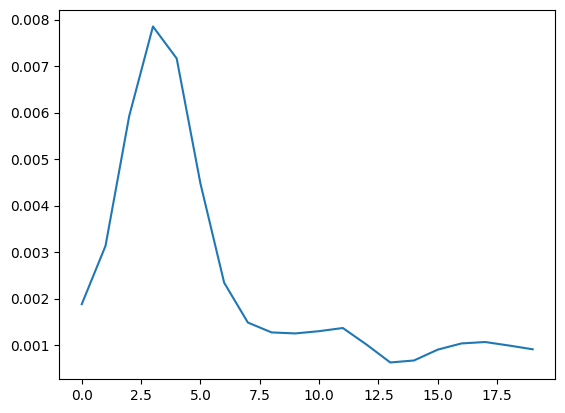

In [52]:
# Plot the training loss over epochs
plt.plot(range(epochs), losses)

In [53]:
# Build GRU Model
class GRUModel(nn.Module):
    """
    GRUModel class defines the architecture of the GRU model.

    Args:
        input_size (int): Number of features in the input.
        hidden_layer_size (int): Number of units in the hidden layer.
        output_size (int): Number of features in the output.

    Attributes:
        gru: GRU layer.
        linear: Linear layer.
        hidden_cell: Hidden cell state for GRU.
    """
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size)  # GRU layer
        self.linear = nn.Linear(hidden_layer_size, output_size)  # Linear layer
        self.hidden_cell = torch.zeros(1,1,self.hidden_layer_size)  # Initialize hidden cell state for GRU

    def forward(self, input_seq):
        """
        Forward pass through the GRU model.

        Args:
            input_seq (torch.Tensor): Input sequence.

        Returns:
            torch.Tensor: Predictions from the model.
        """
        gru_out, self.hidden_cell = self.gru(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)  # GRU forward pass
        preds = self.linear(gru_out.view(len(input_seq), -1))  # Linear layer forward pass
        return preds[-1]  # Return predictions for the last time step

In [54]:
# Initialize GRU model and optimizer
model_gru = GRUModel()  # Initialize GRU model
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Move GRU model to the appropriate device (GPU or CPU)
model_gru = model_gru.to(device)

In [55]:
# Training GRU Model
for i in tqdm(range(epochs)):
    epoch_loss = 0  # Initialize epoch loss to 0
    for seq, labels in zip(x_train, y_train):  # Iterate over training sequences and labels
        seq, labels = seq.to(device), labels.to(device)  # Move sequences and labels to device (GPU or CPU)
        optimizer_gru.zero_grad()  # Zero the gradients
        model_gru.hidden_cell = torch.zeros(1, 1, model_gru.hidden_layer_size).to(device)  # Reset hidden cell state

        y_pred = model_gru(seq)  # Forward pass: compute predicted values

        single_loss = loss_function(y_pred, labels)  # Compute loss for the current sequence
        single_loss.backward()  # Backpropagation: compute gradients
        optimizer_gru.step()  # Update model parameters based on gradients

        epoch_loss += single_loss.item()  # Accumulate the loss for the epoch

    # Calculate and print average loss for the epoch
    epoch_loss /= len(x_train)
    losses.append(epoch_loss)
    print(f'Epoch [{i}/{epochs}], Loss: {epoch_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0/20], Loss: 0.0029360498657699905
Epoch [1/20], Loss: 0.0003046179875784869
Epoch [2/20], Loss: 0.0004666835382544814
Epoch [3/20], Loss: 0.00035503024711581066
Epoch [4/20], Loss: 0.0001585915404837274
Epoch [5/20], Loss: 0.0001798669180594742
Epoch [6/20], Loss: 0.00020987058082351715
Epoch [7/20], Loss: 0.0002618342069206538
Epoch [8/20], Loss: 0.0004358625236405303
Epoch [9/20], Loss: 0.0005039142082123088
Epoch [10/20], Loss: 0.0009413747344345737
Epoch [11/20], Loss: 0.0012399783243846343
Epoch [12/20], Loss: 0.001361291730702088
Epoch [13/20], Loss: 0.000582084724578527
Epoch [14/20], Loss: 0.0006780601354699657
Epoch [15/20], Loss: 4.155271784454602e-05
Epoch [16/20], Loss: 5.017910642779537e-05
Epoch [17/20], Loss: 6.0843645415598895e-05
Epoch [18/20], Loss: 6.222183400738991e-05
Epoch [19/20], Loss: 2.8842518352932598e-05


In [57]:
model_path = os.path.join(models_path, 'gru.pth')
save_arima_model(model_lstm, model_path)

Model saved successfully as trained_models\gru.pth


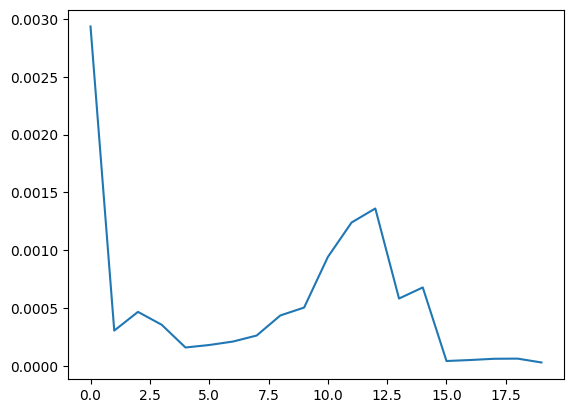

In [58]:
# Plot the training loss over epochs
plt.plot(range(epochs), losses[20:])  # Plot the training loss starting from epoch 20

In [59]:
# Forecast ARIMA before Fourier transform
forecast_stat = model_arima_stat_fit.forecast(steps=24)  # Forecast using ARIMA model before Fourier transform
forecast_stat  # Display the forecasted values

1234    0.134729
1235   -0.047852
1236    0.024715
1237    0.077590
1238   -0.082100
1239    0.137923
1240   -0.081509
1241    0.078753
1242    0.018334
1243   -0.033638
1244    0.112809
1245   -0.085610
1246    0.109926
1247   -0.030613
1248    0.019373
1249    0.070036
1250   -0.064131
1251    0.114711
1252   -0.059441
1253    0.063682
1254    0.022635
1255   -0.026408
1256    0.096392
1257   -0.064721
Name: predicted_mean, dtype: float64

In [60]:
# Forecast ARIMA after Fourier transform
# Forecast Model 24 Months into the Future
forecast_fourier = model_arima_fourier_fit.forecast(steps=24)  # Forecast using ARIMA model after Fourier transform
forecast_fourier  # Display the forecasted values

array([-0.00726769, -0.00725874, -0.0072675 , -0.00725859, -0.00726731,
       -0.00725844, -0.00726712, -0.00725829, -0.00726693, -0.00725814,
       -0.00726674, -0.00725799, -0.00726655, -0.00725785, -0.00726636,
       -0.0072577 , -0.00726617, -0.00725755, -0.00726598, -0.0072574 ,
       -0.00726579, -0.00725725, -0.0072656 , -0.0072571 ])

In [61]:
# Perform forecasting with LSTM model
initial_sequence = torch.tensor(x_test).view(-1).float().to(device)  # Initial sequence for forecasting
forecast_lstm = []  # List to store LSTM forecasts
model_lstm.eval()  # Set LSTM model to evaluation mode

# Perform 24-month forecasting
for _ in tqdm(range(len(x_test))):
    with torch.no_grad():  # Disable gradient tracking during inference
        pred = model_lstm(initial_sequence)  # Get prediction from LSTM model
        forecast_lstm.append(pred.item())  # Append prediction to forecast list
        initial_sequence = torch.cat((initial_sequence[1:], torch.tensor([pred.item()]).to(device)))  # Update input sequence

# Inverse scale the LSTM forecasts
forecast_lstm = scaler_output.inverse_transform(np.array(forecast_lstm).reshape(-1, 1))
forecast_lstm  # Display the LSTM forecasts

  0%|          | 0/24 [00:00<?, ?it/s]

array([[ 0.03084808],
       [-0.03130161],
       [-0.07567464],
       [-0.1058812 ],
       [-0.11966954],
       [-0.11382839],
       [-0.09145691],
       [-0.06677833],
       [-0.0553761 ],
       [-0.05937551],
       [-0.0708383 ],
       [-0.08228829],
       [-0.08942961],
       [-0.09056885],
       [-0.08651268],
       [-0.08026453],
       [-0.07541286],
       [-0.0739705 ],
       [-0.07562088],
       [-0.07868145],
       [-0.08139664],
       [-0.0826811 ],
       [-0.08234295],
       [-0.08094978]])

In [62]:
# Perform forecasting with GRU model
forecast_gru = []  # List to store GRU forecasts
initial_sequence = torch.tensor(x_test).view(-1).float().to(device)  # Initial sequence for forecasting

# Perform 24-month forecasting
for _ in tqdm(range(len(x_test))):
    with torch.no_grad():  # Disable gradient tracking during inference
        pred = model_gru(initial_sequence)  # Get prediction from GRU model
        forecast_gru.append(pred.item())  # Append prediction to forecast list
        initial_sequence = torch.cat((initial_sequence[1:], torch.tensor([pred.item()]).to(device)))  # Update input sequence

# Inverse scale the GRU forecasts
forecast_gru = scaler_output.inverse_transform(np.array(forecast_gru).reshape(-1, 1))
forecast_gru  # Display the GRU forecasts

  0%|          | 0/24 [00:00<?, ?it/s]

array([[0.16375964],
       [0.23585199],
       [0.34152704],
       [0.49261784],
       [0.70471332],
       [0.99166289],
       [1.35658785],
       [1.7947921 ],
       [2.36114829],
       [3.08368879],
       [3.30586832],
       [3.37262996],
       [3.381824  ],
       [3.37005935],
       [3.35913943],
       [3.35285666],
       [3.35006915],
       [3.34931982],
       [3.34965823],
       [3.35054389],
       [3.3516674 ],
       [3.35284377],
       [3.35396083],
       [3.3549493 ]])

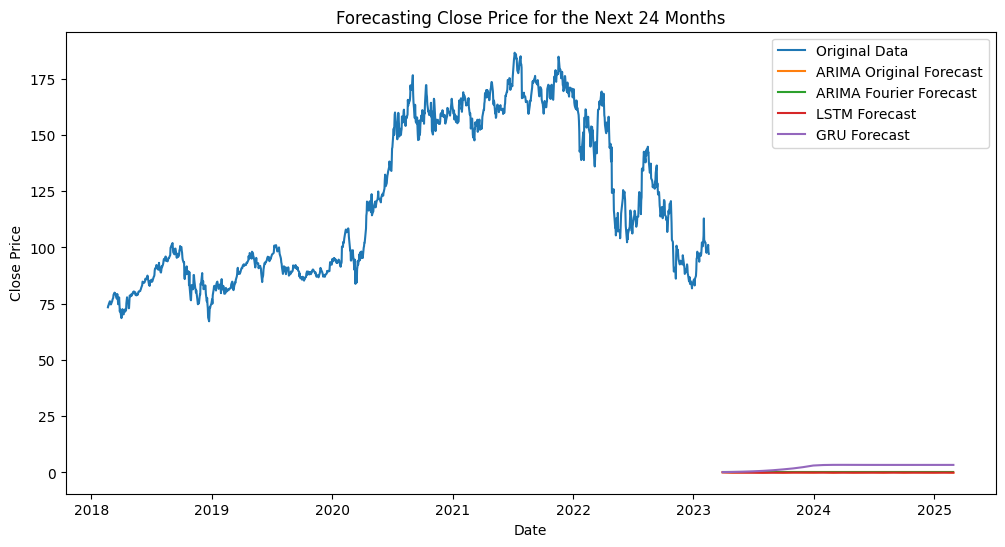

In [63]:
# Plot the Forecasts
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(data1.index, data1['Close'], label='Original Data')  # Plot original data
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], model_arima_stat_fit.forecast(steps=24), label='ARIMA Original Forecast')  # Plot ARIMA original forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], model_arima_fourier_fit.forecast(steps=24), label='ARIMA Fourier Forecast')  # Plot ARIMA Fourier forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], forecast_lstm, label='LSTM Forecast')  # Plot LSTM forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], forecast_gru, label='GRU Forecast')  # Plot GRU forecast
plt.title('Forecasting Close Price for the Next 24 Months')  # Set plot title
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Close Price')  # Set y-axis label
plt.legend()  # Show legend
plt.show()  # Display the plot

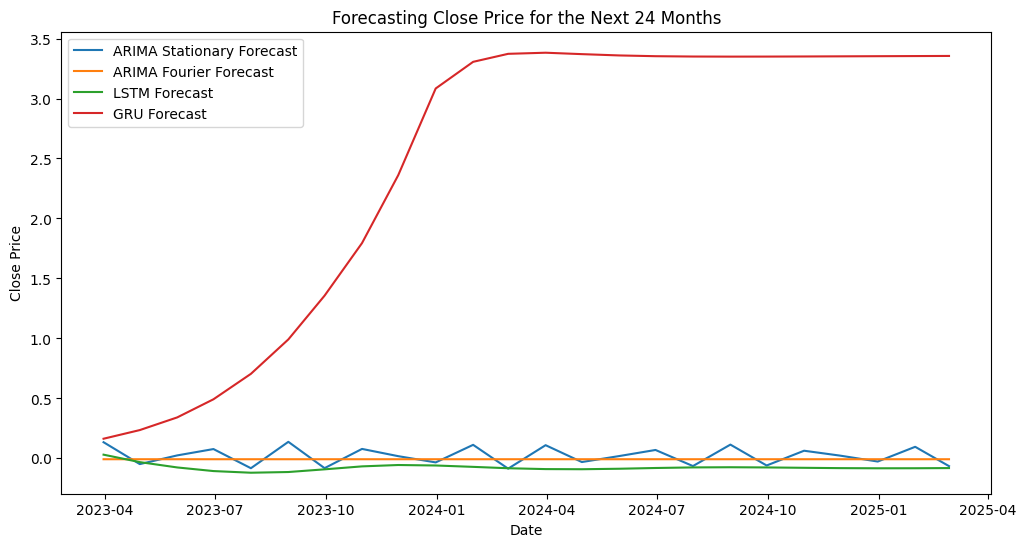

In [64]:
# Plot the Forecasts
plt.figure(figsize=(12, 6))  # Set the figure size
# Plot ARIMA stationary forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], model_arima_stat_fit.forecast(steps=24), label='ARIMA Stationary Forecast')
# Plot ARIMA Fourier forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], model_arima_fourier_fit.forecast(steps=24), label='ARIMA Fourier Forecast')
# Plot LSTM forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], forecast_lstm, label='LSTM Forecast')
# Plot GRU forecast
plt.plot(pd.date_range(start=data1.index[-1], periods=25, freq='M')[1:], forecast_gru, label='GRU Forecast')
plt.title('Forecasting Close Price for the Next 24 Months')  # Set the plot title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Close Price')  # Set the y-axis label
plt.legend()  # Show the legend
plt.show()  # Display the plot

# Evaluation Metrics

In [259]:
rmse_stat = np.sqrt(mean_squared_error(stat_test, forecast_stat))
print('RMSE for Stationary ARIMA:', rmse_stat)

rmse_fur = np.sqrt(mean_squared_error(fourier_test, forecast_fourier))
print('RMSE for fourier ARIMA:', rmse_fur)

rmse_lstm = np.sqrt(mean_squared_error(y_test, forecast_lstm))
print('RMSE for LSTM:', rmse_lstm)

rmse_gru = np.sqrt(mean_squared_error(y_test, forecast_gru))
print('RMSE for GRU:', rmse_gru)

RMSE for Stationary ARIMA: 3.0536271226141203
RMSE for fourier ARIMA: 0.07576830484650082
RMSE for LSTM: 0.5530028409145787
RMSE for GRU: 0.9571313990248516


In [65]:
rmse_stat = np.sqrt(mean_squared_error(stat_test, forecast_stat))
print('RMSE for Stationary ARIMA:', rmse_stat)

rmse_fur = np.sqrt(mean_squared_error(fourier_test, forecast_fourier))
print('RMSE for fourier ARIMA:', rmse_fur)

rmse_lstm = np.sqrt(mean_squared_error(y_test, forecast_lstm))
print('RMSE for LSTM:', rmse_lstm)

rmse_gru = np.sqrt(mean_squared_error(y_test, forecast_gru))
print('RMSE for GRU:', rmse_gru)

RMSE for Stationary ARIMA: 3.0536271226141203
RMSE for fourier ARIMA: 0.07576830484650082
RMSE for LSTM: 0.6199778629767029
RMSE for GRU: 2.241607262518821


# For jj.csv file

In [66]:
# Load the dataset
data2 = pd.read_csv("data/jj.csv")
data2['Date'] = pd.to_datetime(data2['date'])
data2.set_index('Date', inplace=True)

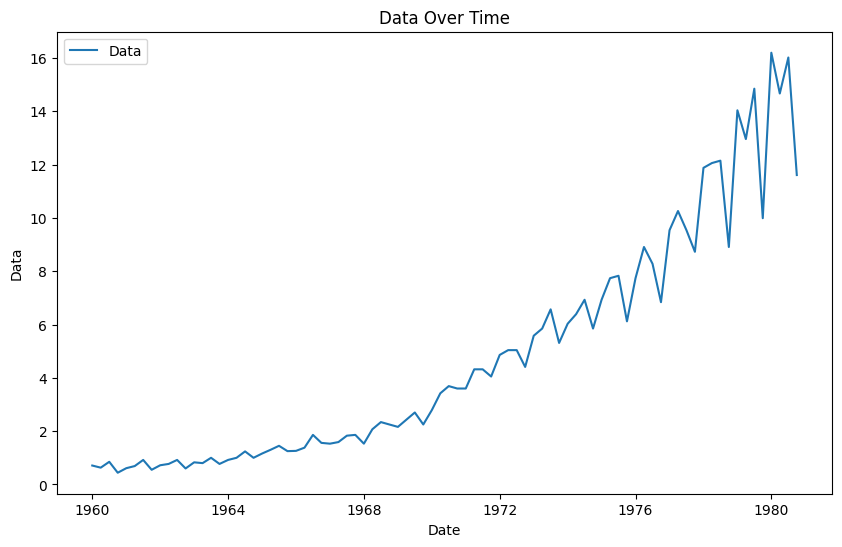

In [67]:
# Initial Plots of the Data
plt.figure(figsize=(10, 6))
plt.plot(data2.index, data2['data'], label='Data')
plt.title('Data Over Time')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.show()

ADF Statistic: 2.7420165734574713
p-value: 1.0
Critical Values: {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}
Data is not stationary


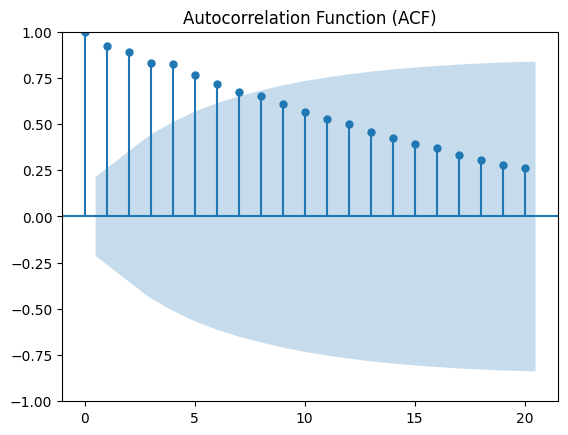

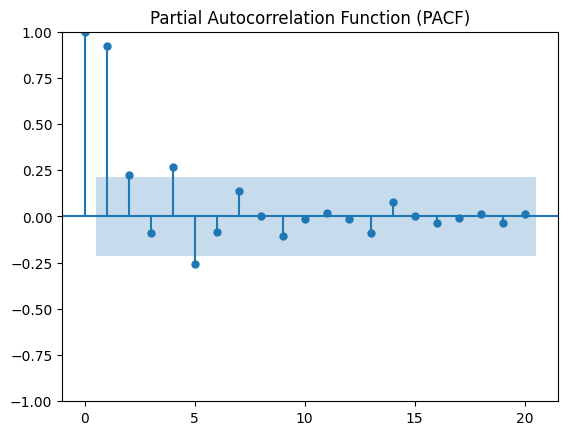

In [68]:
check_stationarity(data2['data'])

# Plot ACF and PACF
plot_acf(data2['data'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data2['data'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

ADF Statistic: -0.40740976363802184
p-value: 0.9088542416911347
Critical Values: {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}
Data is not stationary


ADF Statistic: -3.58516287479319
p-value: 0.006051099869602965
Critical Values: {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}
Data is stationary


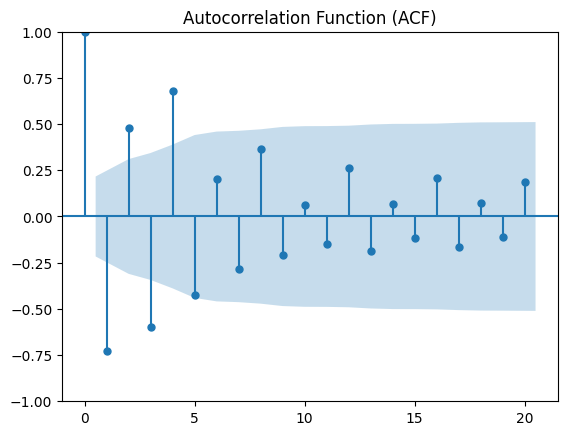

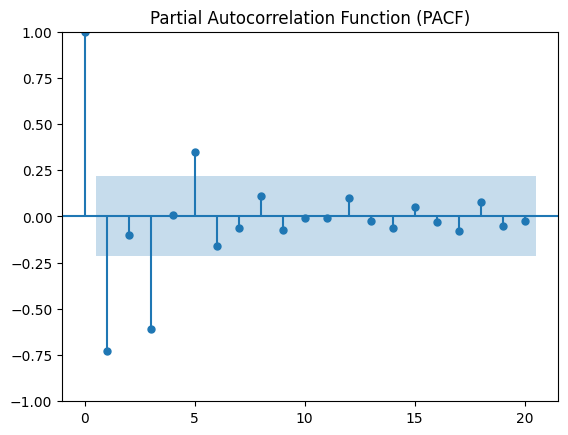

In [69]:
# Make the Data Stationary
data2_diff = data2['data'].diff().dropna()
# Check Stationarity Again
check_stationarity(data2_diff)

print('\n')

# Make the Data Stationary
data2_diff_2 = data2_diff.diff().dropna()
# Check Stationarity Again
check_stationarity(data2_diff_2)


# Plot ACF and PACF
plot_acf(data2_diff_2)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data2_diff_2)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

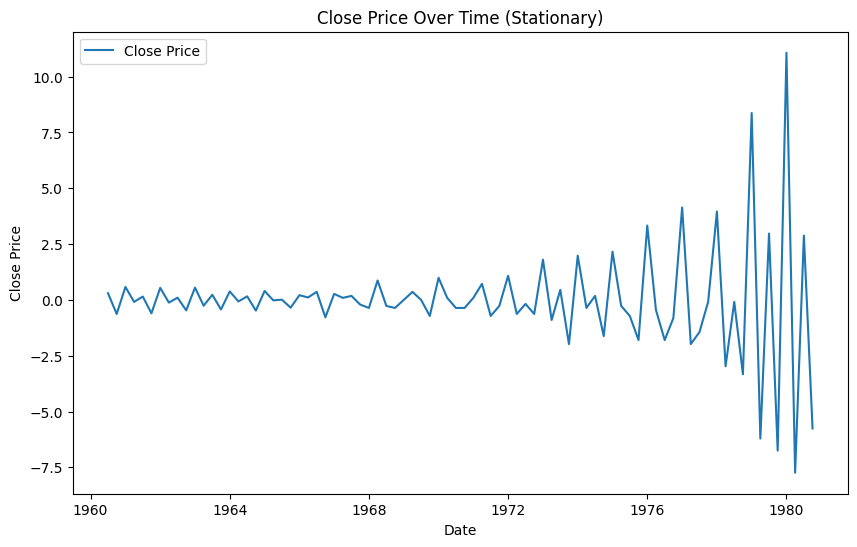

In [70]:
# Initial Plots of the Data
plt.figure(figsize=(10, 6))
plt.plot(data2_diff_2.index, data2_diff_2, label='Close Price')
plt.title('Close Price Over Time (Stationary)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [71]:
best_order = find_best_arima_parameters(data2_diff_2)
print('Best ARIMA Order:', best_order)

  0%|          | 0/3 [00:00<?, ?it/s]

Best ARIMA Order: (2, 0, 2)


In [72]:
# Split the data into train and test sets
stat_train, stat_test = split_time_series_data(data2_diff_2)

In [73]:
# Train ARIMA Model
model_arima_stat = ARIMA(stat_train, order=best_order)
model_arima_stat_fit = model_arima_stat.fit()
model_arima_stat_fit

In [78]:
models_path = os.path.join('trained_models', 'jj_file')
os.makedirs(models_path, exist_ok=True)

In [79]:
model_path = os.path.join(models_path, 'arima_stat.pkl')
save_arima_model(model_arima_stat_fit, model_path)

Model saved successfully as trained_models\jj_file\arima_stat.pkl


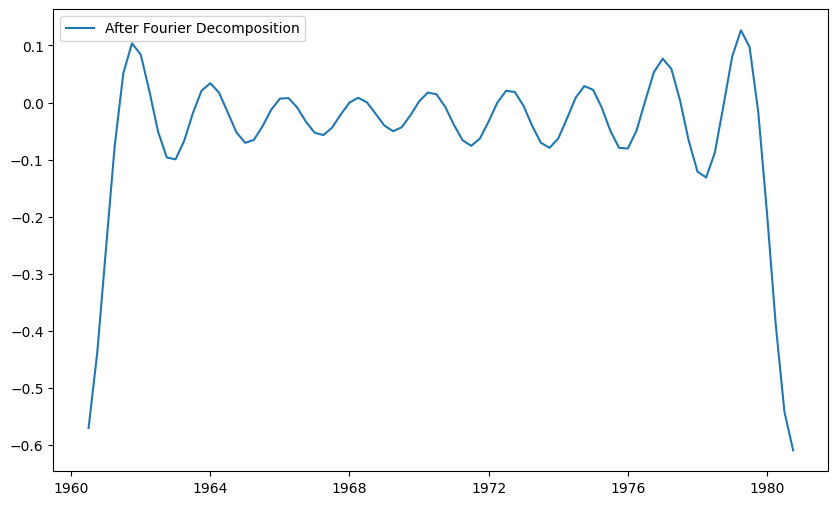

In [80]:
n_periods = 10  # Number of periods to keep in the decomposition
reconstructed_data = fourier_decomposition(data2_diff_2, n_periods)

# Plot the reconstructed data
plt.figure(figsize=(10, 6))
plt.plot(data2_diff_2.index, reconstructed_data, label='After Fourier Decomposition')
plt.legend()
plt.show()

In [81]:
# Split the data into train and test sets
fourier_train, fourier_test = split_time_series_data(reconstructed_data)
model_arima_fourier = ARIMA(fourier_train, order=best_order)
model_arima_fourier_fit = model_arima_fourier.fit()
model_arima_fourier_fit

In [82]:
model_path = os.path.join(models_path, 'arima_fourier.pkl')
save_arima_model(model_arima_fourier_fit, model_path)

Model saved successfully as trained_models\jj_file\arima_fourier.pkl


In [83]:
n_steps = 30
X, y = prepare_data(np.array(reconstructed_data), n_steps)
x_train, x_test, scaler_input = split_time_series_data(X, scale=True)
y_train, y_test, scaler_output = split_time_series_data(y, scale=True)

  0%|          | 0/52 [00:00<?, ?it/s]

In [84]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

model_lstm = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
print('Device name:', torch.cuda.get_device_name())

Device: cuda
Device name: NVIDIA GeForce RTX 2050


In [86]:
model_lstm = model_lstm.to(device)

In [87]:
epochs = 20
losses = []

for epoch in tqdm(range(1, epochs + 1)):  # Start epoch from 1
    epoch_loss = 0
    for seq, labels in zip(x_train, y_train):
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        model_lstm.hidden_cell = (torch.zeros(1, 1, model_lstm.hidden_layer_size).to(device),
                                  torch.zeros(1, 1, model_lstm.hidden_layer_size).to(device))

        y_pred = model_lstm(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()  # Accumulate the loss for the epoch

    # Calculate and print average loss for the epoch
    epoch_loss /= len(x_train)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch}/{epochs}], Loss: {epoch_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.18455388976508402
Epoch [2/20], Loss: 0.1067084139592274
Epoch [3/20], Loss: 0.1043610558005769
Epoch [4/20], Loss: 0.10097809282511402
Epoch [5/20], Loss: 0.10053333490369758
Epoch [6/20], Loss: 0.09963149813224195
Epoch [7/20], Loss: 0.09901430529498612
Epoch [8/20], Loss: 0.09841798253442643
Epoch [9/20], Loss: 0.09787882406713574
Epoch [10/20], Loss: 0.09745785617269576
Epoch [11/20], Loss: 0.09683421613382441
Epoch [12/20], Loss: 0.09631849276463202
Epoch [13/20], Loss: 0.09573698530169038
Epoch [14/20], Loss: 0.09511310676108613
Epoch [15/20], Loss: 0.0943219985201722
Epoch [16/20], Loss: 0.09330004325602204
Epoch [17/20], Loss: 0.09137559140279856
Epoch [18/20], Loss: 0.08741975244837315
Epoch [19/20], Loss: 0.09189713412112203
Epoch [20/20], Loss: 0.08559485631017846


In [88]:
model_path = os.path.join(models_path, 'lstm.pth')
save_arima_model(model_lstm, model_path)

Model saved successfully as trained_models\jj_file\lstm.pth


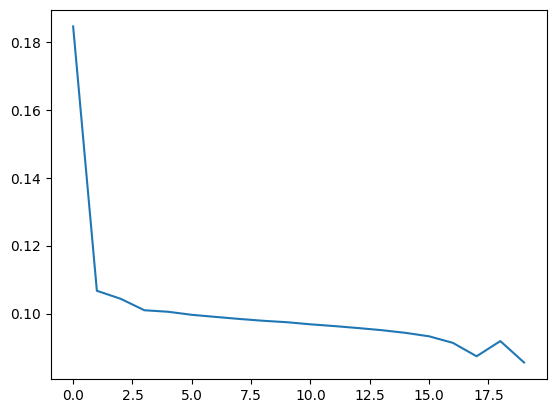

In [89]:
plt.plot(range(epochs), losses)

In [90]:
model_gru = GRUModel()
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
model_gru = model_gru.to(device)

In [91]:
# Training GRU Model
for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in zip(x_train, y_train):
        seq, labels = seq.to(device), labels.to(device)
        optimizer_gru.zero_grad()
        model_gru.hidden_cell = torch.zeros(1, 1, model_gru.hidden_layer_size).to(device)

        y_pred = model_gru(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer_gru.step()

        epoch_loss += single_loss.item()  # Accumulate the loss for the epoch

    # Calculate and print average loss for the epoch
    epoch_loss /= len(x_train)
    losses.append(epoch_loss)
    print(f'Epoch [{i}/{epochs}], Loss: {epoch_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0/20], Loss: 0.1557398758346348
Epoch [1/20], Loss: 0.09680048013251508
Epoch [2/20], Loss: 0.0967682035989128
Epoch [3/20], Loss: 0.09566473775495458
Epoch [4/20], Loss: 0.09485729442323125
Epoch [5/20], Loss: 0.0940948277607926
Epoch [6/20], Loss: 0.09338761101649393
Epoch [7/20], Loss: 0.09271822853458746
Epoch [8/20], Loss: 0.09206153611012269
Epoch [9/20], Loss: 0.09139246008219613
Epoch [10/20], Loss: 0.09067526641592849
Epoch [11/20], Loss: 0.08985141574365636
Epoch [12/20], Loss: 0.08879406420549328
Epoch [13/20], Loss: 0.0870804290570959
Epoch [14/20], Loss: 0.08000525144806099
Epoch [15/20], Loss: 0.0645749137454134
Epoch [16/20], Loss: 0.06479131924312956
Epoch [17/20], Loss: 0.07324969780165702
Epoch [18/20], Loss: 0.04605444979512997
Epoch [19/20], Loss: 0.07638671401322686


In [92]:
model_path = os.path.join(models_path, 'gru.pth')
save_arima_model(model_lstm, model_path)

Model saved successfully as trained_models\jj_file\gru.pth


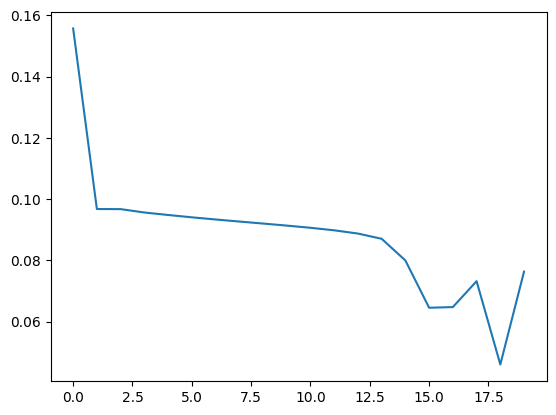

In [93]:
plt.plot(range(epochs), losses[20:])

In [36]:
# Forcast ARIMA before fourier transform
# Forecast Model 24 Months into the Future
forecast_stat = model_arima_stat_fit.forecast(steps=24)
forecast_stat

58    1.839313
59   -1.007963
60    0.861083
61   -0.814988
62    0.801345
63   -0.778304
64    0.769087
65   -0.747314
66    0.738820
67   -0.717669
68    0.709769
69   -0.689198
70    0.681866
71   -0.661851
72    0.655065
73   -0.635585
74    0.629323
75   -0.610356
76    0.604597
77   -0.586123
78    0.580847
79   -0.562847
80    0.558036
81   -0.540490
Name: predicted_mean, dtype: float64

In [37]:
# Forcast ARIMA after fourier transform
# Forecast Model 24 Months into the Future
forecast_fourier = model_arima_fourier_fit.forecast(steps=24)
forecast_fourier

array([ 0.02562485,  0.00439843, -0.02679247, -0.06130749, -0.09197827,
       -0.1125935 , -0.11915256, -0.11063593, -0.08914499, -0.05939757,
       -0.02769765, -0.00060321,  0.01642688,  0.02012878,  0.01005293,
       -0.01140922, -0.03958282, -0.06852328, -0.09226715, -0.10605773,
       -0.10729409, -0.09601515, -0.07483006, -0.04832222])

In [38]:
initial_sequence = torch.tensor(x_test).view(-1).float().to(device)
forecast_lstm = []
model_lstm.eval()

# Perform 24-month forecasting
for _ in tqdm(range(len(x_test))):
    with torch.no_grad():
        pred = model_lstm(initial_sequence)
        forecast_lstm.append(pred.item())
        initial_sequence = torch.cat((initial_sequence[1:], torch.tensor([pred.item()]).to(device)))

forecast_lstm = scaler_output.inverse_transform(np.array(forecast_lstm).reshape(-1, 1))
forecast_lstm

  0%|          | 0/24 [00:00<?, ?it/s]

array([[-0.03763584],
       [-0.03061426],
       [-0.02632423],
       [-0.02530007],
       [-0.02685696],
       [-0.02936765],
       [-0.03127157],
       [-0.03192798],
       [-0.03161439],
       [-0.03093649],
       [-0.03036387],
       [-0.03009255],
       [-0.03009582],
       [-0.03023959],
       [-0.03039026],
       [-0.03047465],
       [-0.03048507],
       [-0.0304516 ],
       [-0.03041017],
       [-0.03038335],
       [-0.03037639],
       [-0.03038307],
       [-0.03039392],
       [-0.03040203]])

In [39]:
# Forecast with GRU
forecast_gru = []
initial_sequence = torch.tensor(x_test).view(-1).float().to(device)
for _ in tqdm(range(len(x_test))):
    with torch.no_grad():
        pred = model_gru(initial_sequence)
        forecast_gru.append(pred.item())
        initial_sequence = torch.cat((initial_sequence[1:], torch.tensor([pred.item()]).to(device)))

forecast_gru = scaler_output.inverse_transform(np.array(forecast_gru).reshape(-1, 1))
forecast_gru

  0%|          | 0/24 [00:00<?, ?it/s]

array([[-0.04541306],
       [-0.03661463],
       [-0.03023459],
       [-0.0279398 ],
       [-0.02845113],
       [-0.02992078],
       [-0.03115672],
       [-0.03179479],
       [-0.0319613 ],
       [-0.03191013],
       [-0.031828  ],
       [-0.03179277],
       [-0.03180741],
       [-0.03184663],
       [-0.03188704],
       [-0.03191734],
       [-0.03193643],
       [-0.03194784],
       [-0.0319555 ],
       [-0.03196184],
       [-0.03196776],
       [-0.03197329],
       [-0.0319782 ],
       [-0.03198236]])

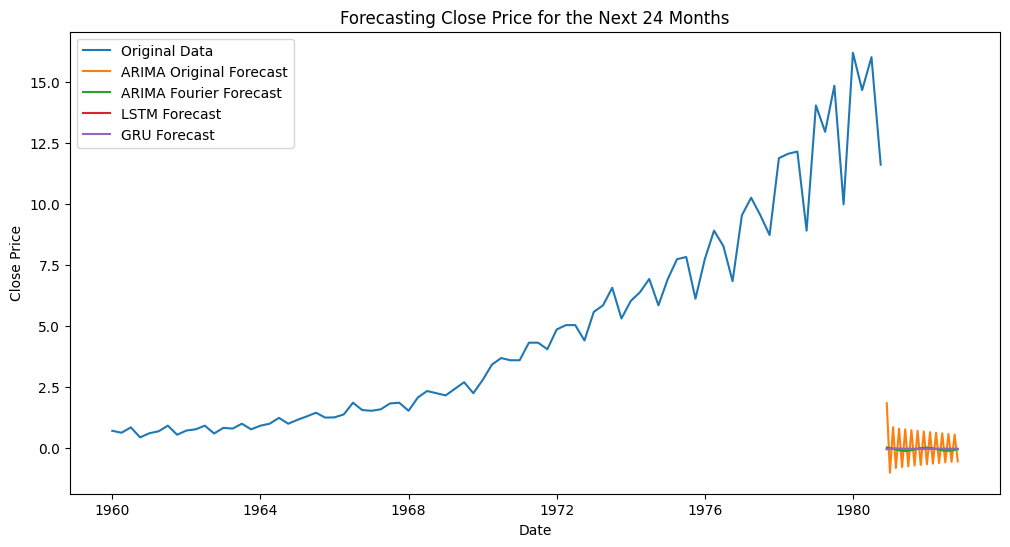

In [40]:
# Plot the Forecasts
plt.figure(figsize=(12, 6))
plt.plot(data2.index, data2['data'], label='Original Data')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], model_arima_stat_fit.forecast(steps=24), label='ARIMA Original Forecast')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], model_arima_fourier_fit.forecast(steps=24), label='ARIMA Fourier Forecast')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], forecast_lstm, label='LSTM Forecast')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], forecast_gru, label='GRU Forecast')
plt.title('Forecasting Close Price for the Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

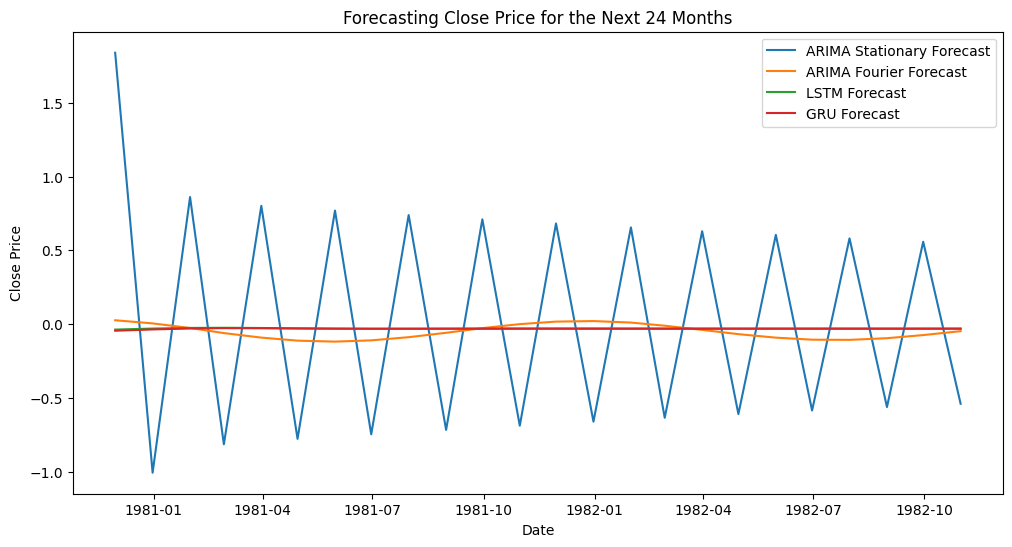

In [41]:
# Plot the Forecasts
plt.figure(figsize=(12, 6))
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], model_arima_stat_fit.forecast(steps=24), label='ARIMA Stationary Forecast')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], model_arima_fourier_fit.forecast(steps=24), label='ARIMA Fourier Forecast')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], forecast_lstm, label='LSTM Forecast')
plt.plot(pd.date_range(start=data2.index[-1], periods=25, freq='M')[1:], forecast_gru, label='GRU Forecast')
plt.title('Forecasting Close Price for the Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [42]:
rmse_stat = np.sqrt(mean_squared_error(stat_test, forecast_stat))
print('RMSE for Stationary ARIMA:', rmse_stat)

rmse_fur = np.sqrt(mean_squared_error(fourier_test, forecast_fourier))
print('RMSE for fourier ARIMA:', rmse_fur)

rmse_lstm = np.sqrt(mean_squared_error(y_test, forecast_lstm))
print('RMSE for LSTM:', rmse_lstm)

rmse_gru = np.sqrt(mean_squared_error(y_test, forecast_gru))
print('RMSE for GRU:', rmse_gru)

RMSE for Stationary ARIMA: 4.0222587106932055
RMSE for fourier ARIMA: 0.19001567931033816
RMSE for LSTM: 1.6966578771541467
RMSE for GRU: 1.6967527759519636


# THE END !